<a href="https://colab.research.google.com/github/qilin512/OUC-ComputerVision/blob/main/PoisonImageEditing/Poison_Image_Editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poison Image Editing

[有代码的中文博客](https://blog.csdn.net/weixin_43194305/article/details/104928378)，这篇算是写的最清晰详细的，并对泊松方程的解法有介绍。

[一篇知乎上的解读文章](https://zhuanlan.zhihu.com/p/453095752)。

[这篇](https://blog.csdn.net/zhaoyin214/article/details/88196575)中文参考资料，详细的图文解释。

这是一篇英文的参考资料: [An Intuitive Explanation of using Poisson Blending for Seamless Copy-and-Paste of Images](https://erkaman.github.io/posts/poisson_blending.html)，文章末尾有作者的C++代码实现。

另外一篇比较详细的[英文资料](https://www.ctralie.com/Teaching/PoissonImageEditing/)，文后也有作者实现的Java代码。

MATLAB社区的[代码](https://ww2.mathworks.cn/matlabcentral/fileexchange/62287-poisson-image-editing)，有GUI可交互操作。

国外计算机课程将其作为经典方法留作作业：

- UIUC在2017年的课程CS445 Computational Photography，有[该作业](https://courses.engr.illinois.edu/cs445/fa2017/projects/gradient/ComputationalPhotography_ProjectGradient.html)。
- 布朗大学(Brown)也有类似的[作业](https://cs.brown.edu/courses/csci1290/asgn/proj3_poisson/index.html)。

参考图像（大部分来自论文原文中使用的图像）在压缩包里一起打包了（img文件夹）。

In [29]:
import numpy as np
import cv2
import scipy.sparse as sp

def check_neighbor_exist(mask, i, j):
    h, w = mask.shape
    if i >= 0 and i < h and j >= 0 and j < w:
        if mask[i][j]:
            return True
        else:
            return False
    return False

def create_coefficient_matrix(nonzero_list, mask, neighbor_flag, mask_nonzero_idx):
    N = nonzero_list.shape[0]
    A = sp.lil_matrix((N, N), dtype=np.float32) #创建一个空的稀疏矩阵
    for i in range(N):
        A[i, i] = 4
        i_h, i_w = nonzero_list[i]
        if neighbor_flag[i][0]:
            j = mask_nonzero_idx[i_h - 1][i_w]
            A[i, j] = -1
        if neighbor_flag[i][1]:
            j = mask_nonzero_idx[i_h + 1][i_w]
            A[i, j] = -1
        if neighbor_flag[i][2]:
            j = mask_nonzero_idx[i_h][i_w - 1]
            A[i, j] = -1
        if neighbor_flag[i][3]:
            j = mask_nonzero_idx[i_h][i_w + 1]
            A[i, j] = -1
    return A

def compute_gradient(src, coordinate, neighbor_flag):
    x, y = coordinate

    #
    N = np.sum(neighbor_flag == True) 
    ret = N * src[x, y]
    if neighbor_flag[0]:
        ret -= float(src[x - 1, y])
    if neighbor_flag[1]:
        ret -= float(src[x + 1, y])
    if neighbor_flag[2]:
        ret -= float(src[x, y - 1])
    if neighbor_flag[3]:
        ret -= float(src[x, y + 1])
    return ret

def constrain(dst, coordinate, contour, neighbor_flag):
    x, y = coordinate

    #
    ret = 0.0
    if contour[x][y]:
        if not neighbor_flag[0]:
            ret += dst[x - 1, y]
        if not neighbor_flag[1]:
            ret += dst[x + 1, y]
        if not neighbor_flag[2]:
            ret += dst[x, y - 1]
        if not neighbor_flag[3]:
            ret += dst[x, y + 1] 
    return ret

def make_indices(mask):
    h, w = mask.shape
    nonzero = np.nonzero(mask)  #np.nonzero返回mask中非零元素的坐标,它将每个坐标中的两个值以列表的形式返回
    y = np.reshape(nonzero[0], (nonzero[0].shape[0], 1)) #取出第一个列表,并把它变成二维
    x = np.reshape(nonzero[1], (nonzero[1].shape[0], 1))
    nonzero_list = np.concatenate([y, x], 1)  #这样便把每个坐标放到一个列表中了
    
    neighbor_flag = []  #用于标记邻居是否存在,它的索引对应nonzero_list的索引
    mask_nonzero_idx = np.zeros((h, w), dtype=np.int32) #存储mask中每个非零元素的坐标在nonzero_list中的索引
    for idx in range(nonzero_list.shape[0]):
        i, j = nonzero_list[idx] #坐标
        neighbor_flag.append([check_neighbor_exist(mask, i - 1, j),
                              check_neighbor_exist(mask, i + 1, j),
                              check_neighbor_exist(mask, i, j - 1),
                              check_neighbor_exist(mask, i, j + 1)])
        mask_nonzero_idx[i][j] = idx
    
    return nonzero_list, np.array(neighbor_flag, dtype=bool), mask_nonzero_idx

def PoisonEditing(obj, dst, mask, center, mix_grad=False):
    #提取mask轮廓
    mask = np.array(mask, dtype=np.uint8)
    contour = cv2.erode(mask, np.ones((3, 3), np.uint8))  #先将图像腐蚀(变小)
    contour = mask * (1 - contour) #二者一乘,便得到mask的轮廓

    nonzero_list, neighbor_flag, mask_nonzero_idx = make_indices(mask)
    #Create poisson A matrix
    A = sp.lil_matrix((nonzero_list.shape[0],nonzero_list.shape[0]), dtype=np.float32)
    A = create_coefficient_matrix(nonzero_list, mask, neighbor_flag, mask_nonzero_idx)

    #Create gradient matrix
    m_b = np.zeros(nonzero_list.shape[0])
    m_g = np.zeros(nonzero_list.shape[0])
    m_r = np.zeros(nonzero_list.shape[0])
    for idx in range(nonzero_list.shape[0]):
        m_b[idx] = compute_gradient(obj[:,:,0], nonzero_list[idx], neighbor_flag[idx]) \
                    + constrain(dst[:,:,0], nonzero_list[idx], contour, neighbor_flag[idx])
        m_g[idx] = compute_gradient(obj[:,:,1], nonzero_list[idx], neighbor_flag[idx]) \
                    + constrain(dst[:,:,1], nonzero_list[idx], contour, neighbor_flag[idx])
        m_r[idx] = compute_gradient(obj[:,:,2], nonzero_list[idx], neighbor_flag[idx]) \
                    + constrain(dst[:,:,2], nonzero_list[idx], contour, neighbor_flag[idx])
    #
    x_b, _ = sp.linalg.cg(A, m_b)
    x_g, _ = sp.linalg.cg(A, m_g)
    x_r, _ = sp.linalg.cg(A, m_r)
    #blend
    blend = dst.copy()
    for idx in range(nonzero_list.shape[0]):
        x, y = nonzero_list[idx]
        blend[x, y, 0] = np.clip(x_b[idx], 0.0, 1.0)
        blend[x, y, 1] = np.clip(x_g[idx], 0.0, 1.0)
        blend[x, y, 2] = np.clip(x_r[idx], 0.0, 1.0)
    result = blend.copy()
    return np.array(result * 255, dtype=np.uint8)

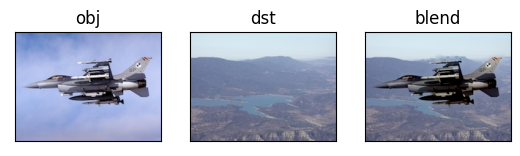

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取前景图像
obj = np.array(cv2.imread('./source.jpg', 1) / 255.0, dtype=np.float32)

# 读取背景图像
dst = np.array(cv2.imread('./target.jpg', 1) / 255.0, dtype = np.float32)

# 读取设置好的mask
mask = np.array(cv2.imread('./mask.jpg', 0), dtype=np.uint8)

# 设置obj拷贝到dst的位置（中心像素）
# 要填充的obj是不规则形状，这里要获得该不规则区域的最小外接矩形（bounding box），
# 以该最小外接矩形的中心作为obj在dst中的位置
cx = 800
cy = 100
center = (cx, cy)

# 调用Poison方法，需要自己复现
result = PoisonEditing(obj, dst, mask / 255.0, center)


plt.subplot(131)
plt.imshow(np.array(obj * 255.0, dtype=np.uint8)[:,:,::-1])
plt.title('obj')
plt.xticks([]),plt.yticks([])
plt.subplot(132)
plt.imshow(np.array(dst * 255.0, dtype=np.uint8)[:,:,::-1])
plt.title('dst')
plt.xticks([]),plt.yticks([])
plt.subplot(133)
plt.imshow(result[:,:,::-1])
plt.title('blend')
plt.xticks([]),plt.yticks([])
plt.show()

# cv2.imshow('result', result)
# while(cv2.waitKey(0) == 27):
#     cv2.destroyAllWindows()
#     break

# 参考OpenCV实现的方法
# normal_clone = cv2.seamlessClone(obj, dst, mask, center, cv2.NORMAL_CLONE)
# mixed_clone = cv2.seamlessClone(obj, dst, mask, center, cv2.MIXED_CLONE)
# cv2.imshow('normal_clone', normal_clone)
# cv2.imshow('mixed_clone', mixed_clone)

# while(cv2.waitKey(0) == 27):
#     cv2.destroyAllWindows()
#     break